1. Dataset Preparation

In [1]:
#import all the necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.text import TfidfVectorizer
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import time
import copy
import os




Load the training dataset and test data.


In [2]:
# Load the training and test datasets (no headers)
train_df = pd.read_csv(
    "https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/train.tsv",
    sep='\t',
    header=None,
    names=["sentence", "label"]
)

test_df = pd.read_csv(
    "https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/test.tsv",
    sep='\t',
    header=None,
    names=["sentence", "label"]
)

In [3]:
train_df.head()

,sentence,label
0,"a stirring , funny and finally transporting re...",1
1,apparently reassembled from the cutting room f...,0
2,they presume their audience wo n't sit still f...,0
3,this is a visually stunning rumination on love...,1
4,jonathan parker 's bartleby should have been t...,1


In [4]:
test_df.head()

,sentence,label
0,"no movement , no yuks , not much of anything",0
1,"a gob of drivel so sickly sweet , even the eag...",0
2,"gangs of new york is an unapologetic mess , wh...",0
3,"we never really feel involved with the story ,...",0
4,this is one of polanski 's best films,1


Use 20% of the training dataset as the validation set.


In [5]:
# Split into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_df["sentence"], train_df["label"], test_size=0.2, random_state=42
)

Construct a Multi-Layer Perceptron (MLP) model.

In [6]:


# Initialize the vectorizer
vectorizer = TfidfVectorizer(max_features=10000)  # You can tune max_features

# Fit on training data and transform train/val
X_train = vectorizer.fit_transform(train_texts).toarray()
X_val = vectorizer.transform(val_texts).toarray()


In [7]:
X_train.shape

(5536, 10000)

In [8]:

y_train = torch.tensor(train_labels.values, dtype=torch.long)
y_val = torch.tensor(val_labels.values, dtype=torch.long)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)


In [9]:
X_train.shape

torch.Size([5536, 10000])

The parameter should be with:<br>
  hidden_sizes=[512, 256, 128, 64]<br>
Output should have two labels.


In [10]:


class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_sizes, output_dim=2):
        super(MLPClassifier, self).__init__()

        layers = []
        in_dim = input_dim
        for h in hidden_sizes:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.ReLU())
            in_dim = h
        layers.append(nn.Linear(in_dim, output_dim))  # Output layer

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


In [11]:
input_dim = X_train.shape[1]
hidden_sizes = [512, 256, 128, 64]

model = MLPClassifier(input_dim=input_dim, hidden_sizes=hidden_sizes)


In [12]:
print(model.state_dict)

<bound method Module.state_dict of MLPClassifier(
  (model): Sequential(
    (0): Linear(in_features=10000, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=2, bias=True)
  )
)>


Count the number of trainable parameters in the model using the automated function

In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Total trainable parameters:", count_parameters(model))


Total trainable parameters: 5293122


Train the model with 10 epochs and create the best-performing model (checkpoint.pt)

In [14]:

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)



In [15]:
epochs = 10
train_losses = []
val_accuracies = []
best_val_acc = 0.0

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    # Validation
    model.eval()
    with torch.no_grad():
        val_preds = model(X_val)
        val_preds_labels = torch.argmax(val_preds, dim=1)
        val_acc = accuracy_score(y_val.cpu(), val_preds_labels.cpu())
        val_accuracies.append(val_acc)

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "checkpoint.pt")

    print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.4f} - Val Acc: {val_acc:.4f}")


Epoch 1/10 - Loss: 0.6929 - Val Acc: 0.5152
Epoch 2/10 - Loss: 0.6922 - Val Acc: 0.5152
Epoch 3/10 - Loss: 0.6913 - Val Acc: 0.5152
Epoch 4/10 - Loss: 0.6899 - Val Acc: 0.5152
Epoch 5/10 - Loss: 0.6879 - Val Acc: 0.5152
Epoch 6/10 - Loss: 0.6845 - Val Acc: 0.5152
Epoch 7/10 - Loss: 0.6798 - Val Acc: 0.5152
Epoch 8/10 - Loss: 0.6736 - Val Acc: 0.5152
Epoch 9/10 - Loss: 0.6658 - Val Acc: 0.5152
Epoch 10/10 - Loss: 0.6561 - Val Acc: 0.5152


Plot the validation accuracy + loss (epochs vs accuracy-loss).

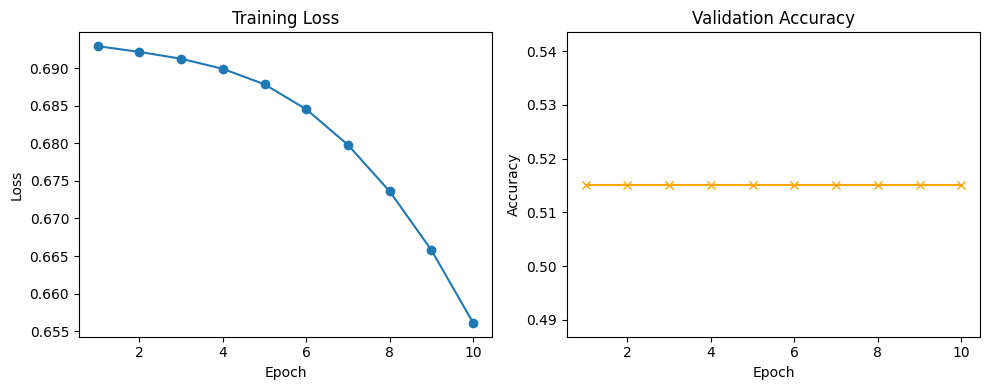

In [16]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), val_accuracies, marker='x', color='orange')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.tight_layout()
plt.show()


In [17]:
model.load_state_dict(torch.load("checkpoint.pt"))
model.eval()


MLPClassifier(
  (model): Sequential(
    (0): Linear(in_features=10000, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ReLU()
    (8): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [18]:
model.state_dict()

OrderedDict([('model.0.weight',
              tensor([[-0.0033,  0.0092, -0.0031,  ..., -0.0092, -0.0089,  0.0054],
                      [-0.0049,  0.0019,  0.0071,  ..., -0.0097, -0.0079, -0.0015],
                      [-0.0057,  0.0039, -0.0012,  ...,  0.0043, -0.0050, -0.0081],
                      ...,
                      [ 0.0067,  0.0021,  0.0080,  ...,  0.0022,  0.0064,  0.0103],
                      [-0.0014, -0.0013, -0.0027,  ...,  0.0001,  0.0088,  0.0092],
                      [-0.0100,  0.0066, -0.0061,  ...,  0.0035, -0.0028, -0.0003]])),
             ('model.0.bias',
              tensor([-7.6554e-03, -4.7924e-03,  5.4157e-03, -3.4969e-03, -5.9657e-03,
                       6.1831e-03,  4.4844e-03,  4.3857e-03,  5.6201e-03, -2.5374e-03,
                       4.8076e-03, -3.8189e-03,  4.6759e-03, -2.1343e-03, -1.2640e-04,
                       8.2336e-03,  4.2781e-04,  3.9007e-03, -7.9150e-03, -4.6813e-03,
                      -6.4016e-03, -2.1817e-04,  3.4058e

In [19]:
test_texts = test_df["sentence"]
X_test = vectorizer.transform(test_texts).toarray()
X_test = torch.tensor(X_test, dtype=torch.float32)
test_labels = test_df["label"]
y_test = torch.tensor(test_labels.values, dtype=torch.long)

In [20]:
import time

def get_avg_inference_time(model, X_test, num_runs=10):
    times = []
    with torch.no_grad():
        for _ in range(num_runs):
            start = time.time()
            _ = model(X_test)
            end = time.time()
            times.append((end - start) * 1000)
    return sum(times) / len(times)  # in ms


In [23]:
model.eval()
with torch.no_grad():
    outputs = model(X_test)
    preds = torch.argmax(outputs, dim=1)

orig_acc = accuracy_score(y_test.cpu(), preds.cpu())
print(f"[Original] Accuracy: {orig_acc:.4f}")
orig_time = get_avg_inference_time(model, X_test)
print(f"[Original] Inference Time: {orig_time:.2f} ms")
torch.save(model.state_dict(), "original.pt")
orig_size = os.path.getsize("original.pt") / (1024 * 1024)
print(f"[Original] Model Size: {orig_size:.2f} MB")

[Original] Accuracy: 0.4992
[Original] Inference Time: 313.35 ms
[Original] Model Size: 20.20 MB


Dynamic Quantization with INT4

In [24]:


# Only linear layers can be quantized dynamically
quantized_model = torch.quantization.quantize_dynamic(
    copy.deepcopy(model),  # make a copy of the model
    {nn.Linear},  # only quantize Linear layers
    dtype=torch.qint8  # use INT8 quantization
)


In [25]:
quantized_model.eval()
with torch.no_grad():
    outputs = quantized_model(X_test)
    preds = torch.argmax(outputs, dim=1)

quantized_accuracy = accuracy_score(y_test, preds)
inference_time_ms = get_avg_inference_time(quantized_model, X_test)

print(f"[Dynamic Quantization] Accuracy: {quantized_accuracy:.4f}, Inference Time: {inference_time_ms:.2f} ms")


[Dynamic Quantization] Accuracy: 0.4992, Inference Time: 214.24 ms


In [26]:
torch.save(quantized_model.state_dict(), "dynamic_quantized.pt")

import os
size_mb = os.path.getsize("dynamic_quantized.pt") / (1024 * 1024)
print(f"[Dynamic Quantization] Model Size: {size_mb:.2f} MB")


[Dynamic Quantization] Model Size: 5.06 MB


In [27]:
quantized_model.state_dict()

OrderedDict([('model.0.scale', tensor(1.)),
             ('model.0.zero_point', tensor(0)),
             ('model.0._packed_params.dtype', torch.qint8),
             ('model.0._packed_params._packed_params',
              (tensor([[-3.2772e-03,  9.2280e-03, -3.1048e-03,  ..., -9.1418e-03,
                        -8.8830e-03,  5.4333e-03],
                       [-4.8296e-03,  1.8973e-03,  7.0719e-03,  ..., -9.6592e-03,
                        -7.9344e-03, -1.5524e-03],
                       [-5.6920e-03,  3.9672e-03, -1.2074e-03,  ...,  4.3122e-03,
                        -5.0021e-03, -8.0206e-03],
                       ...,
                       [ 6.7270e-03,  2.0698e-03,  8.0206e-03,  ...,  2.2423e-03,
                         6.3820e-03,  1.0349e-02],
                       [-1.3799e-03, -1.2936e-03, -2.7598e-03,  ...,  8.6243e-05,
                         8.7968e-03,  9.2280e-03],
                       [-1.0004e-02,  6.6407e-03, -6.1233e-03,  ...,  3.4497e-03,
                  

Half Precision

In [29]:
# Only safe if model supports it — works fine for MLPs
half_model = copy.deepcopy(model).half()
X_test_half = X_test.half()  # Also convert input
half_model.eval()
with torch.no_grad():
    outputs = half_model(X_test_half)
    preds = torch.argmax(outputs, dim=1)

half_accuracy = accuracy_score(y_test, preds)
half_inference_time_ms = get_avg_inference_time(half_model, X_test_half)

print(f"[Half Precision] Accuracy: {half_accuracy:.4f}, Inference Time: {half_inference_time_ms:.2f} ms")

torch.save(half_model.state_dict(), "half_precision.pt")
size_mb_half = os.path.getsize("half_precision.pt") / (1024 * 1024)
print(f"[Half Precision] Model Size: {size_mb_half:.2f} MB")


[Half Precision] Accuracy: 0.4992, Inference Time: 2430.92 ms
[Half Precision] Model Size: 10.10 MB


In [30]:
half_model.state_dict()

OrderedDict([('model.0.weight',
              tensor([[-0.0033,  0.0092, -0.0031,  ..., -0.0092, -0.0089,  0.0054],
                      [-0.0049,  0.0019,  0.0071,  ..., -0.0097, -0.0079, -0.0015],
                      [-0.0057,  0.0039, -0.0012,  ...,  0.0043, -0.0050, -0.0081],
                      ...,
                      [ 0.0067,  0.0021,  0.0080,  ...,  0.0022,  0.0064,  0.0103],
                      [-0.0014, -0.0013, -0.0027,  ...,  0.0001,  0.0088,  0.0092],
                      [-0.0100,  0.0066, -0.0061,  ...,  0.0035, -0.0028, -0.0003]],
                     dtype=torch.float16)),
             ('model.0.bias',
              tensor([-7.6561e-03, -4.7913e-03,  5.4169e-03, -3.4962e-03, -5.9662e-03,
                       6.1836e-03,  4.4861e-03,  4.3869e-03,  5.6190e-03, -2.5368e-03,
                       4.8065e-03, -3.8185e-03,  4.6768e-03, -2.1343e-03, -1.2636e-04,
                       8.2321e-03,  4.2772e-04,  3.9005e-03, -7.9117e-03, -4.6806e-03,
              

Fill the table for different quantization techniques.

In [31]:

# Final Table
data = {
    "Model Name": ["Original", "Dynamic", "Half"],
    "Accuracy (Out of 100)": [round(orig_acc * 100, 2), round(quantized_accuracy * 100, 2), round(half_accuracy * 100, 2)],
    "Storage (In MB)": [round(orig_size, 2), round(size_mb, 2), round(size_mb_half, 2)],
    "Inference time (In ms)": [round(orig_time, 2), round(inference_time_ms, 2), round(half_inference_time_ms, 2)],
}

results_df = pd.DataFrame(data)
print("\n Final Quantization Comparison Table:")
print(results_df.to_markdown(index=False))



 Final Quantization Comparison Table:
| Model Name   |   Accuracy (Out of 100) |   Storage (In MB) |   Inference time (In ms) |
|:-------------|------------------------:|------------------:|-------------------------:|
| Original     |                   49.92 |             20.2  |                   313.35 |
| Dynamic      |                   49.92 |              5.06 |                   214.24 |
| Half         |                   49.92 |             10.1  |                  2430.92 |


Half Precision With GPU

In [32]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


half_model_gpu = copy.deepcopy(model).half().to(device)
X_test_half_gpu = X_test.half().to(device)


half_model_gpu.eval()
with torch.no_grad():
    outputs_gpu = half_model_gpu(X_test_half_gpu)
    preds_gpu = torch.argmax(outputs_gpu, dim=1)

half_accuracy_gpu = accuracy_score(y_test.cpu(), preds_gpu.cpu())

# Measure average inference time over multiple runs
def get_avg_inference_time_gpu(model, X_test, num_runs=10):
    times = []
    with torch.no_grad():
        for _ in range(num_runs):
            start = time.time()
            _ = model(X_test)
            if device.type == "cuda":
                torch.cuda.synchronize()  # wait for GPU to finish
            end = time.time()
            times.append((end - start) * 1000)  # ms
    return sum(times) / len(times)

avg_time_ms = get_avg_inference_time_gpu(half_model_gpu, X_test_half_gpu)

# Save and get model size
torch.save(half_model_gpu.state_dict(), "half_precision_gpu.pt")
size_mb_half_gpu = os.path.getsize("half_precision_gpu.pt") / (1024 * 1024)

# Final Output
print(f"[Half Precision - {device.type.upper()}] Accuracy: {half_accuracy_gpu:.4f}, Inference Time (avg): {avg_time_ms:.2f} ms")
print(f"[Half Precision GPU] Model Size: {size_mb_half_gpu:.2f} MB")


[Half Precision - CUDA] Accuracy: 0.4992, Inference Time (avg): 1.36 ms
[Half Precision GPU] Model Size: 10.10 MB


In [34]:

# Final Table
data = {
    "Model Name": ["Original", "Dynamic", "Half", "Half( WITH GPU)"],
    "Accuracy (Out of 100)": [round(orig_acc * 100, 2), round(quantized_accuracy * 100, 2), round(half_accuracy * 100, 2),round(half_accuracy_gpu * 100, 2)],
    "Storage (In MB)": [round(orig_size, 2), round(size_mb, 2), round(size_mb_half, 2),round(size_mb_half_gpu, 2)],
    "Inference time (In ms)": [round(orig_time, 2), round(inference_time_ms, 2), round(half_inference_time_ms, 2),round(avg_time_ms, 2)],
}

results_df = pd.DataFrame(data)
print("\n Final Quantization Comparison Table:")
print(results_df.to_markdown(index=False))



 Final Quantization Comparison Table:
| Model Name      |   Accuracy (Out of 100) |   Storage (In MB) |   Inference time (In ms) |
|:----------------|------------------------:|------------------:|-------------------------:|
| Original        |                   49.92 |             20.2  |                   313.35 |
| Dynamic         |                   49.92 |              5.06 |                   214.24 |
| Half            |                   49.92 |             10.1  |                  2430.92 |
| Half( WITH GPU) |                   49.92 |             10.1  |                     1.36 |


Half-precision (FP16) models are slower on CPU because most CPUs lack native support for FP16 arithmetic and optimized instructions to handle it efficiently. As a result, CPUs often emulate FP16 operations using slower FP32 computations, which introduces overhead and significantly increases inference time. This makes FP16 unsuitable for CPU inference, even though it performs exceptionally well on GPUs that are designed to accelerate half-precision operations.